In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from sklearn.metrics import mean_absolute_error as mae
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Add, Flatten, Dense, Reshape, BatchNormalization, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow import convert_to_tensor
from unet_architecture import build_unet_w_penalty

In [2]:
class ModelBuilder(Model):

    def __init__(self, patch_size, penalty):
        super(ModelBuilder, self).__init__()
        self.cnn = build_unet_w_penalty((patch_size[0], patch_size[1], 1), penalty)
                    
    def call(self, x):                 
        return self.cnn(x)   

    def summary(self):
        return self.cnn.summary()

In [3]:
nx_cmp = 40
nt = 448

cmp_model = ModelBuilder((nt, nx_cmp, 1), penalty=1e-8)
cmp_model.built = True
cmp_model.load_weights('./models/cmp_model_weights.h5')

Model: "model"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_1 (InputLayer)                            [(None, 448, 40, 1)]             0                 []                                                
                                                                                                                                                      
 conv2d (Conv2D)                                 (None, 448, 40, 16)              160               ['input_1[0][0]']                                 
                                                                                                                                                      
 conv2d_1 (Conv2D)                               (None, 448, 40, 16)           

                                                                                                                                                      
Total params: 535,505
Trainable params: 535,505
Non-trainable params: 0
______________________________________________________________________________________________________________________________________________________


In [4]:
nx_shot = 72

shot_model = ModelBuilder((nt, nx_shot, 1), penalty=1e-8)
shot_model.built = True
shot_model.load_weights('./models/shot_model_weights.h5')

Model: "model_1"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_2 (InputLayer)                            [(None, 448, 72, 1)]             0                 []                                                
                                                                                                                                                      
 conv2d_15 (Conv2D)                              (None, 448, 72, 16)              160               ['input_2[0][0]']                                 
                                                                                                                                                      
 conv2d_16 (Conv2D)                              (None, 448, 72, 16)         

                                                                                                                                                      
Total params: 535,505
Trainable params: 535,505
Non-trainable params: 0
______________________________________________________________________________________________________________________________________________________


# Predict on Example Synthetic CMP and Shot Gather

In [5]:
# load the gathers (all true data)
cmp_synth = np.load('./example_data/cmp_synth.npy')
shot_synth = np.load('./example_data/shot_synth.npy')

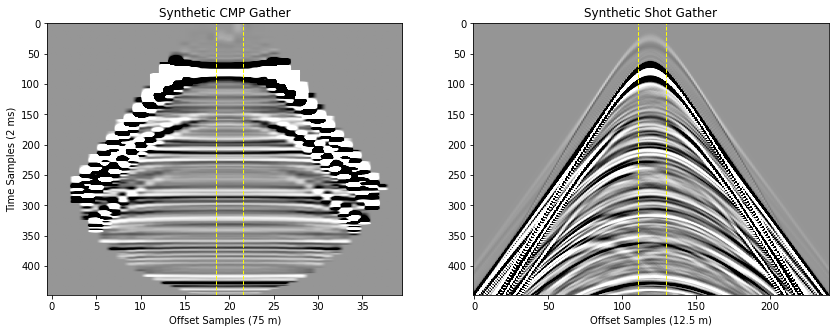

In [6]:
fig,ax = plt.subplots(1, 2, figsize=(14,5))
c=0.02
ax[0].imshow(cmp_synth, aspect='auto', cmap='Greys', vmin=-c, vmax=c)
# plot the near offset region to interpolate as dashed-yellow lines
ax[0].axvline(19.5-1, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[0].axvline(19.5+2, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[0].set_xlabel('Offset Samples (75 m)')
ax[0].set_ylabel('Time Samples (2 ms)')
ax[0].set_title('Synthetic CMP Gather');

ax[1].imshow(shot_synth, aspect='auto', cmap='Greys', vmin=-c, vmax=c)
ax[1].axvline(119.5-9, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[1].axvline(119.5+10, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[1].set_xlabel('Offset Samples (12.5 m)')
ax[1].set_title('Synthetic Shot Gather');

In [7]:
# zero out the near-offset region (3 traces) to prepare for input to CNN
cmp_synth_input = np.copy(cmp_synth)
cmp_synth_input[:, 19:22] = 0

# expand dimensions to fit Tensorflow input
cmp_synth_input = np.expand_dims(np.expand_dims(cmp_synth_input, axis=2), axis=0)


shot_synth_input = np.copy(shot_synth)
# zoom in on 72-trace-wide window around shot gather as input
shot_synth_input = shot_synth_input[:, 120-36:120+36]

# zero out the near-offset region (18 traces) to prepare for input to CNN
shot_synth_input[:, 36-9:36+10] = 0

# expand dimensions to fit Tensorflow input
shot_synth_input = np.expand_dims(np.expand_dims(shot_synth_input, axis=2), axis=0)

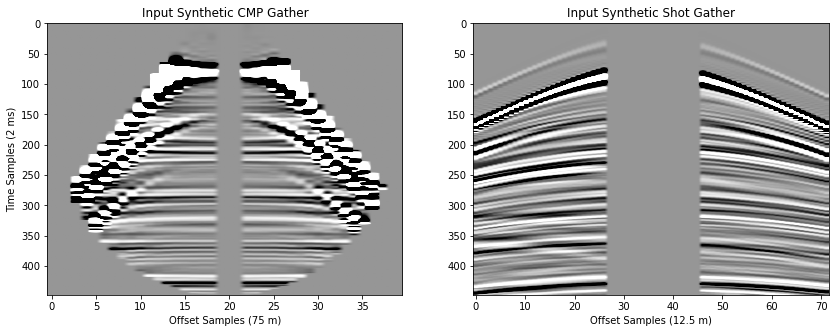

In [8]:
fig,ax = plt.subplots(1, 2, figsize=(14,5))
c=0.02
ax[0].imshow(cmp_synth_input[0,:,:,0], aspect='auto', cmap='Greys', vmin=-c, vmax=c)
ax[0].set_xlabel('Offset Samples (75 m)')
ax[0].set_ylabel('Time Samples (2 ms)')
ax[0].set_title('Input Synthetic CMP Gather');

ax[1].imshow(shot_synth_input[0,:,:,0], aspect='auto', cmap='Greys', vmin=-c, vmax=c)
ax[1].set_xlabel('Offset Samples (12.5 m)')
ax[1].set_title('Input Synthetic Shot Gather');

In [9]:
# make prediction with CMP model
cmp_synth_pred = cmp_model.cnn(convert_to_tensor(cmp_synth_input)).numpy()

# extract data from expanded Tensorflow dimensions
cmp_synth_pred = cmp_synth_pred[0,:,:,0]

# calculate difference between prediction and target
diff_cmp = cmp_synth - cmp_synth_pred
# zero out residual error outside the near-offset region
diff_cmp[:, :19] = 0
diff_cmp[:, 22:] = 0



# make prediction with shot model
shot_synth_pred = shot_model.cnn(convert_to_tensor(shot_synth_input)).numpy()
# extract data from expanded Tensorflow dimensions
shot_synth_pred = shot_synth_pred[0,:,:,0]
# concatenate back with original data to get full gather
shot_synth_pred = np.concatenate((shot_synth[:, :120-36], shot_synth_pred, shot_synth[:, 120+36:]), axis=1)

# calculate difference between prediction and target
diff_shot = shot_synth - shot_synth_pred
# zero out residual error outside the near-offset region
diff_shot[:, :111] = 0
diff_shot[:, 129:] = 0

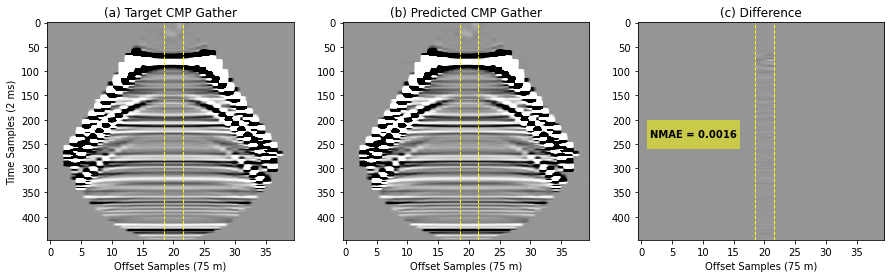

In [10]:
fig,ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].imshow(cmp_synth, cmap='Greys', aspect='auto', vmin=-c, vmax=c)
ax[0].axvline(19.5-1, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[0].axvline(19.5+2, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[0].set_xlabel('Offset Samples (75 m)')
ax[0].set_ylabel('Time Samples (2 ms)')
ax[0].set_title('(a) Target CMP Gather')

ax[1].imshow(cmp_synth_pred, cmap='Greys', aspect='auto', vmin=-c, vmax=c)
ax[1].axvline(19.5-1, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[1].axvline(19.5+2, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[1].set_xlabel('Offset Samples (75 m)')
ax[1].set_title('(b) Predicted CMP Gather')

ax[2].imshow(diff_cmp, cmap='Greys', aspect='auto', vmin=-c, vmax=c)
ax[2].axvline(19.5-1, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[2].axvline(19.5+2, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[2].set_xlabel('Offset Samples (75 m)')
ax[2].set_title('(c) Difference')

rect = patches.Rectangle((1,200), 15, 60, linewidth=7, facecolor='yellow', edgecolor=None, alpha=0.5)
ax[2].add_patch(rect)
rx, ry = rect.get_xy()
cx = rx + rect.get_width()/2.0
cy = ry + rect.get_height()/2.0
# calculate normalized mean absolute error between prediction and target
cmp_error = round(mae(cmp_synth[:,19:22], cmp_synth_pred[:,19:22]) /
            (np.max(cmp_synth[:,19:22]) - np.min(cmp_synth[:,19:22])), 4)
ax[2].annotate("NMAE = "+str(cmp_error), (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center');

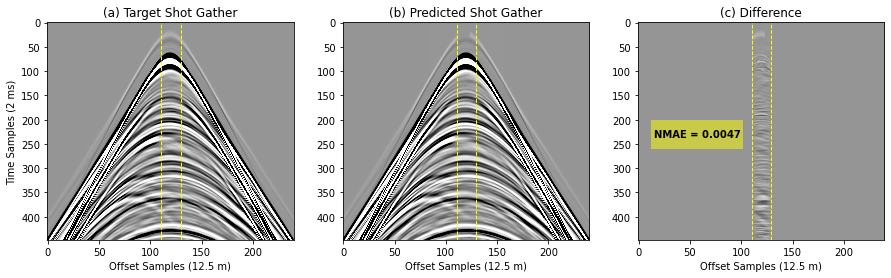

In [11]:
fig,ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].imshow(shot_synth, cmap='Greys', aspect='auto', vmin=-c, vmax=c)
ax[0].axvline(119.5-9, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[0].axvline(119.5+10, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[0].set_xlabel('Offset Samples (12.5 m)')
ax[0].set_ylabel('Time Samples (2 ms)')
ax[0].set_title('(a) Target Shot Gather')

ax[1].imshow(shot_synth_pred, cmap='Greys', aspect='auto', vmin=-c, vmax=c)
ax[1].axvline(119.5-9, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[1].axvline(119.5+10, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[1].set_xlabel('Offset Samples (12.5 m)')
ax[1].set_title('(b) Predicted Shot Gather')

ax[2].imshow(diff_shot, cmap='Greys', aspect='auto', vmin=-c, vmax=c)
ax[2].axvline(119.5-9, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[2].axvline(119.5+10, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[2].set_xlabel('Offset Samples (12.5 m)')
ax[2].set_title('(c) Difference')

rect = patches.Rectangle((12,200), 90, 60, linewidth=7, facecolor='yellow', edgecolor=None, alpha=0.5)
ax[2].add_patch(rect)
rx, ry = rect.get_xy()
cx = rx + rect.get_width()/2.0
cy = ry + rect.get_height()/2.0
shot_error = round(mae(shot_synth[:, 120-9:120+10], shot_synth_pred[:,120-9:120+10]) /
            (np.max(shot_synth[:,120-9:120+10]) - np.min(shot_synth[:,120-9:120+10])), 4)
ax[2].annotate("NMAE = "+str(shot_error), (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center');

# Predict on TopSeis Field CMP Gather

In [12]:
cmp_field = np.load('./example_data/cmp_field.npy')

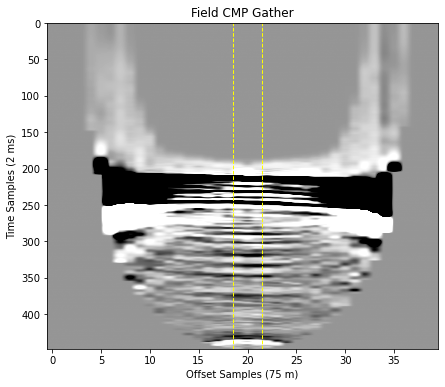

In [13]:
fig,ax = plt.subplots(figsize=(7,6))
c=0.03
ax.imshow(cmp_field, aspect='auto', cmap='Greys', vmin=-c, vmax=c)
ax.axvline(19.5-1, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax.axvline(19.5+2, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax.set_xlabel('Offset Samples (75 m)')
ax.set_ylabel('Time Samples (2 ms)')
ax.set_title('Field CMP Gather');

In [14]:
# zero out the near-offset region (3 traces) to prepare for input to CNN
cmp_field_input = np.copy(cmp_field)
cmp_field_input[:, 19:22] = 0

# expand dimensions to fit Tensorflow input
cmp_field_input = np.expand_dims(np.expand_dims(cmp_field_input, axis=2), axis=0)

# make prediction with CMP model
cmp_field_pred = cmp_model.cnn(convert_to_tensor(cmp_field_input)).numpy()

# extract data from expanded Tensorflow dimensions
cmp_field_pred = cmp_field_pred[0,:,:,0]

# calculate difference between prediction and target
diff_cmp_field = cmp_field - cmp_field_pred
# zero out residual error outside the near-offset region
diff_cmp_field[:, :19] = 0
diff_cmp_field[:, 22:] = 0

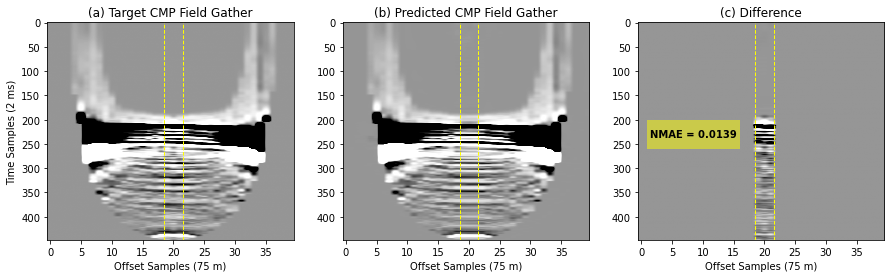

In [15]:
fig,ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].imshow(cmp_field, cmap='Greys', aspect='auto', vmin=-c, vmax=c)
ax[0].axvline(19.5-1, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[0].axvline(19.5+2, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[0].set_xlabel('Offset Samples (75 m)')
ax[0].set_ylabel('Time Samples (2 ms)')
ax[0].set_title('(a) Target CMP Field Gather')

ax[1].imshow(cmp_field_pred, cmap='Greys', aspect='auto', vmin=-c, vmax=c)
ax[1].axvline(19.5-1, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[1].axvline(19.5+2, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[1].set_xlabel('Offset Samples (75 m)')
ax[1].set_title('(b) Predicted CMP Field Gather')

ax[2].imshow(diff_cmp_field, cmap='Greys', aspect='auto', vmin=-c, vmax=c)
ax[2].axvline(19.5-1, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[2].axvline(19.5+2, linestyle='--', linewidth=1, markeredgecolor='white', color='yellow')
ax[2].set_xlabel('Offset Samples (75 m)')
ax[2].set_title('(c) Difference')

rect = patches.Rectangle((1,200), 15, 60, linewidth=7, facecolor='yellow', edgecolor=None, alpha=0.5)
ax[2].add_patch(rect)
rx, ry = rect.get_xy()
cx = rx + rect.get_width()/2.0
cy = ry + rect.get_height()/2.0
cmp_error_field = round(mae(cmp_field[:,19:22], cmp_field_pred[:,19:22]) /
            (np.max(cmp_field[:,19:22]) - np.min(cmp_field[:,19:22])), 4)
ax[2].annotate("NMAE = "+str(cmp_error_field), (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center');